Add to my cbow (from Neural Networks for Sequence Modeling/layer_1 ) most_similar method based on cosine similarity and make this code more flexible


### Import libs and data

In [ ]:
import torch
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
dataset = load_dataset('imdb')
train_data = dataset['train']
test_data = dataset['test']

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[12500 12500]


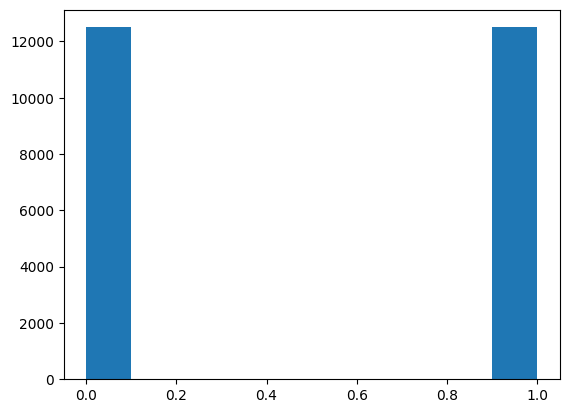

In [ ]:
labels, counts = np.unique(train_data['label'], return_counts=True)
print(counts)
plt.hist(train_data['label'])
plt.show()

#### constants for cbow

### Preprocessing components



In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F

nltk.download('punkt_tab')
nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))
def tokenize(text):
    return [
        token for token in word_tokenize(text.lower())
        if token.isalpha() and token not in english_stopwords
    ]

class Vocabulary:
  def __init__(self, texts=None, min_freq=5, unk_token='<UNK>', pad_token='<PAD>'):
    self.unk_token = unk_token
    self.pad_token = pad_token
    self.min_freq = min_freq
    self._word2idx = {}
    self._idx2word = {}
    self.tokens_counts = Counter()
    if texts is not None:
      self.build_vocabulary(texts)
  def build_vocabulary(self, texts):
    for text in texts:
      tokens = tokenize(text)
      self.tokens_counts.update(tokens)

    self.add_token(self.unk_token)
    self.add_token(self.pad_token)

    for token, count in self.tokens_counts.items():
      if count >= self.min_freq:
        self.add_token(token)

  def add_token(self, token):
    if token not in self._word2idx:
      idx = len(self)
      self._word2idx[token] = idx
      self._idx2word[idx] = token

  def __len__(self):
    return len(self._word2idx)
  def get_word_by_idx(self, idx):
    if idx in self._idx2word:
      return self._idx2word[idx]
    return self.unk_token
  def get_idx_by_word(self, word):
    if word in self._word2idx:
      return self._word2idx[word]
    return self._word2idx[self.unk_token]




class CBOWDataset(Dataset):
  def __init__(self, texts, vocab, window_size=2):
    self.texts = texts
    self.vocab = vocab
    self.window_size = window_size
    self.pairs = self._generate_cbow_pairs()
  def _generate_cbow_pairs(self):
    pairs = []
    for text in self.texts:
      tokens = tokenize(text)
      indexed_tokens = [self.vocab.get_idx_by_word(token) for token in tokens]
      unk_token_idx = self.vocab.get_idx_by_word(self.vocab.unk_token)
      pad_token_idx = self.vocab.get_idx_by_word(self.vocab.pad_token)
      n = len(indexed_tokens)
      for i in range(n):
        target_word_idx = indexed_tokens[i]
        if target_word_idx == unk_token_idx or target_word_idx == pad_token_idx:
          # ignore unk_token as central words - it's counterproductive cause we shouldn't say cbow "you are not right, you've predicted not unk_token"
          continue
        context_indices = []
        for j in range(max(0, i - self.window_size), i):
          context_indices.append(indexed_tokens[j])
        for j in range(i + 1, min(n, i + 1 + self.window_size)):
          context_indices.append(indexed_tokens[j])

        if context_indices:
          pairs.append((context_indices, target_word_idx))


    return pairs
  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    context, target = self.pairs[idx]
    return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)




class CBOW(nn.Module):
  def __init__(self, vocab_size, embedding_dim):
    super().__init__()
    self.context_embeddings = nn.EmbeddingBag(vocab_size, embedding_dim, sparse=True, mode='mean')
    self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
  def forward(self, context_indices, offsets):
    embedded_context = self.context_embeddings(context_indices, offsets)
    return embedded_context @ self.target_embeddings.weight.T

  def most_similar_words(self, idx, k=1):
    self.eval()
    with torch.no_grad():
      all_embeddings = self.target_embeddings.weight
      embedding = all_embeddings[idx]

      normalized_embedding = F.normalize(embedding, p=2, dim=0)
      normalized_all_embeddings = F.normalize(all_embeddings, p=2, dim=1)

      cosine_similarities = normalized_all_embeddings @ normalized_embedding.T

      cosine_similarities[idx] = -float('inf')

      topk_values, topk_indices = torch.topk(cosine_similarities, k=k, largest=True, sorted=True)
      return {topk_indices[i].item(): round(topk_values[i].item(), 2) for i in range(k)}




def cbow_collate_fn(batch):
  context_tensors = []
  target_tensors = []
  for item in batch:
    context_tensors.append(item[0])
    target_tensors.append(item[1])
  context_tensors_flatten = torch.cat(context_tensors)
  offsets = [0] + [len(c) for c in context_tensors]
  offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
  return context_tensors_flatten, offsets, torch.stack(target_tensors)



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
gpu_t4 = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UNKNOWN_TOKEN = '<UNK>'
PADDING_TOKEN = '<PAD>'
BATCH_SIZE = 512
MIN_FREQUENCY = 5
WINDOW_SIZE = 2
EMBEDDING_DIM = 100

In [ ]:
data = load_dataset('imdb')
train_data = data['train']
test_data = data['test']
train_texts = train_data['text']
vocab = Vocabulary(train_texts, min_freq=MIN_FREQUENCY, pad_token=PADDING_TOKEN, unk_token=UNKNOWN_TOKEN)

cbow_dataset = CBOWDataset(train_texts, vocab, window_size=2)
cbow_dataloader = DataLoader(cbow_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=cbow_collate_fn)

In [ ]:
cbow_model = CBOW(len(vocab), embedding_dim=EMBEDDING_DIM).to(gpu_t4)
top_10_movie_similars = cbow_model.most_similar_words(vocab.get_idx_by_word('movie'), k = 10)
for key in top_10_movie_similars.keys():
  print(f"{vocab.get_word_by_idx(key)}: {top_10_movie_similars[key]}")

natalia: 0.42
caveman: 0.38
kumar: 0.38
modernist: 0.36
forming: 0.35
textured: 0.34
inverted: 0.33
resembles: 0.33
fatally: 0.33
separately: 0.32


/tmp/ipython-input-244876777.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3725.)
  cosine_similarities = normalized_all_embeddings @ normalized_embedding.T


#### Train CBOW

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  batches_count = len(dataloader)
  model.train()
  for batch, (context_indices, offsets, target_word_idx) in enumerate(dataloader):
    context_indices, offsets, target_word_idx = context_indices.to(gpu_t4), offsets.to(gpu_t4), target_word_idx.to(gpu_t4)

    optimizer.zero_grad()

    pred = model(context_indices, offsets)

    loss = loss_fn(pred, target_word_idx)

    loss.backward()
    optimizer.step()

    if (batch +1) % 100 == 0 or batch == batches_count -1:
      loss, current = loss.item(), batch * BATCH_SIZE + len(context_indices)
      print(f'loss: {loss:>7f} [{current:>5d}/{size:>5d}]')

In [9]:
cbow_loss_fn = nn.CrossEntropyLoss()
cbow_optimizer = torch.optim.SGD(cbow_model.parameters(), lr=1e-2, momentum=0.8)
for epoch in range(10):
  print(f'\n\n\n---------------------EPOCH {epoch}------------------\n')
  train_loop(cbow_dataloader, cbow_model, cbow_loss_fn, cbow_optimizer)




---------------------EPOCH 0------------------

loss: 22.237307 [52714/2892132]
loss: 21.573999 [103917/2892132]
loss: 21.419586 [155105/2892132]
loss: 21.339518 [206319/2892132]
loss: 21.474401 [257499/2892132]
loss: 20.865707 [308706/2892132]
loss: 21.049643 [359907/2892132]
loss: 20.650835 [411108/2892132]
loss: 20.458881 [462304/2892132]
loss: 21.104401 [513518/2892132]
loss: 20.735323 [564708/2892132]
loss: 21.401474 [615903/2892132]
loss: 20.538464 [667107/2892132]
loss: 20.521175 [718307/2892132]
loss: 20.660736 [769511/2892132]
loss: 20.447094 [820696/2892132]
loss: 20.438040 [871906/2892132]
loss: 20.647251 [923107/2892132]
loss: 20.413202 [974313/2892132]
loss: 20.336451 [1025511/2892132]
loss: 20.797626 [1076702/2892132]
loss: 19.906778 [1127915/2892132]
loss: 20.123816 [1179107/2892132]
loss: 20.568182 [1230307/2892132]
loss: 20.298880 [1281516/2892132]
loss: 20.775480 [1332709/2892132]
loss: 20.081350 [1383911/2892132]
loss: 20.224796 [1435108/2892132]
loss: 20.680965 [

In [10]:
top_10_movie_similars = cbow_model.most_similar_words(vocab.get_idx_by_word('movie'), k = 10)
for key in top_10_movie_similars.keys():
  print(f"{vocab.get_word_by_idx(key)}: {top_10_movie_similars[key]}")

film: 0.73
br: 0.68
really: 0.49
one: 0.49
think: 0.49
like: 0.48
story: 0.48
first: 0.46
would: 0.46
could: 0.44
